In [11]:
import pprint
import json
import random
import math
from copy import copy, deepcopy

In [12]:
def format_value(value):
  if value == '.':
    return '..'
  else:
    s = str(value)
    if len(s) == 1:
      s = ' ' + s
    return s

def format_h(const, max):
  s = ''
  for i in range(max - len(const)):
    s = s + '   '
  s = s + ' '.join(map(format_value, const))
  return s

def pretty_print(board, h_const, v_const):
  max_h = 1
  for c in h_const:
    max_h = max(max_h, len(c))
  max_v = 1
  for c in v_const:
    max_v = max(max_v, len(c))

  h_offset = ' '.join(map(lambda x: '  ', range(max_h)))
  for i in range(max_v):
    print('    ' + h_offset + ' '.join(map(lambda x: '  ' if i >= len(x) else format_value(x[i]), v_const)))
  for r in range(len(board)):
    row = board[r]
    print((h_offset if r ==0 else format_h(h_const[r-1], max_h)) + ' ' +  ' '.join(map(format_value, row)))

Example Kakuro Game

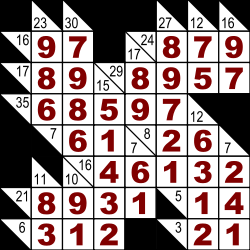

## Precalculations of cells and blocks

### **cells** is a dictionary with
- keys as cell coordinates.
- values as a dictionary with keys

  "value" = current_value_of_the_cell,

  "h_block_id" = id_of_horizontal_block_it_belongs_to,

  "v_block_id" = id_of_vertical_block_it_belongs_to,

  "options"= [list of available value options for this cell]


*if current_value_of_the_cell == 0, then we assume it's empty.

*Each cell belongs to two blocks - vertical and horizontal


---



### **blocks** is a dictionary with
- keys as block ID.
- values as a dictionary with keys

  "sum_left" = sum_left_to_satisfy_the_constraint,

  "cells" = [list_of_cell_coordinates_that_belong_to_this_block]


*Block is a piece of kakuro puzzle that is squeezed between two walls and has specific constraint. We have vertical and horizontal blocks.

*Each block has  unique ID.



In [13]:
from itertools import chain
import copy
from collections import defaultdict

def create_cells_and_blocks(board, h_const, v_const):
  cells = defaultdict(dict)
  blocks = defaultdict(dict)
  block_id = 0
  last = 'X'
  # Horizontal traversal
  h_const_flattened_list = list(chain.from_iterable(h_const))
  for ind_r, row in enumerate(board):
    for ind_c, column in enumerate(board[ind_r]):
      if last=='X' and board[ind_r][ind_c]=='.':
        last = '.'
        block_id +=1
        blocks[block_id]["sum_left"] = h_const_flattened_list[block_id-1]
        blocks[block_id]["cells"] = [] # Initialize list of cells for this block

      if board[ind_r][ind_c]=='.':
        cells[(ind_r, ind_c)]["value"] = 0 # Appending current value
        cells[(ind_r, ind_c)]["h_block_id"] = block_id # Appending horizontal block_id it belongs to
        blocks[block_id]["cells"].append((ind_r, ind_c)) # Appending a cell that belongs to this block
        last = '.'
      else: last = 'X'

  number_of_horizontal_blocks = block_id

  # Vertical traversal
  v_const_flattened_list = list(chain.from_iterable(v_const))
  for ind_c, column in enumerate(board[ind_r]):
    for ind_r, row in enumerate(board):
      if last=='X' and board[ind_r][ind_c]=='.':
        last = '.'
        block_id +=1
        blocks[block_id]["sum_left"] = v_const_flattened_list[block_id-number_of_horizontal_blocks-1]
        blocks[block_id]["cells"] = [] # Initialize list of cells for this block

      if board[ind_r][ind_c]=='.':
        cells[(ind_r, ind_c)]["v_block_id"] = block_id # Appending vertical block_id it belongs to
        cells[(ind_r, ind_c)]["options"] = [] # Appending an empty list for available values the cell could take, it will be filled out later on
        blocks[block_id]["cells"].append((ind_r, ind_c)) # Appending a cell that belongs to this block
        last = '.'
      else: last = 'X'
  return cells, blocks

## Board Class

In [14]:
class Board:
  def __init__(self, cells, blocks, prev, next, last_move_made):
    self.cells = cells
    self.blocks = blocks
    self.prev = prev
    self.next = next
    self.last_move_made = last_move_made

  # Returns -> True if all block constraints are satisfied
  def is_solved(self): # If all constraints equal 0
    sum_of_sums_left = sum([value["sum_left"] for value in self.blocks.values()])
    if sum_of_sums_left==0:
      return True
    return False

  # Returns -> True if the assignment is consistent with constraints
  def consistent(self, empty_cell, value): # Checking whether a value assignment is consistent with constraints
    # check that the value is less than or equal to the sum left for its blocks
    block_h, block_v = self.h_and_v_blocks_of_cell(empty_cell)
    if value > self.blocks[block_h]["sum_left"] or value > self.blocks[block_v]["sum_left"]:
      return False
    # Check that no other cell in the blocks has the same value
    cells_in_same_blocks = self.cells_in_same_blocks(empty_cell, "nonempty")
    for cell_coord in cells_in_same_blocks:
      if cell_coord!=empty_cell and self.cells[cell_coord]["value"]==value:
        return False
    return True

  def constraint_propagation(self, coord, value):
    # Update value of the cell
    self.cells[coord]["value"] = value
    # Update sums left for the block
    for block in list(self.h_and_v_blocks_of_cell(coord)):
      self.blocks[block]["sum_left"] -= value
    # Generate new domains for empty cells in same blocks
    cells_in_same_blocks = self.cells_in_same_blocks(coord, "empty")
    self.generate_domains(cells_in_same_blocks)
    # Remove values from same blocks as an available option from the cells in same blocks
    self.remove_existing_values_from_options(coord)

  def update_due_to_backtracking(self, coord, value):
    # Update cells value back to 0
    self.cells[coord]["value"] = 0
    del self.next
    self.cells[coord]["options"].remove(value) # Removes value from available options of that cell

  # Returns -> a cell that has the least options
  def find_most_constrained_empty_cell(self):
    min_options = 100 # it should not be more than 9 anyways, but still
    min_options_cell = None
    for key, value in self.cells.items():
      if len(value["options"])<=min_options and value["value"]==0:
        min_options = len(value["options"])
        min_options_cell = key
    return min_options_cell

  # Updates options of cells by recursively generating combinations that a cells vertical and horizontal blocks' empty cells could contain
  # And then does an intersection between the two of them to figure out what values that cell can actually take
  def generate_domains(self, coords):
    for coord in coords:
      block_h, block_v = self.h_and_v_blocks_of_cell(coord)
      domain_h, domain_v = self.generate_domain_from_combinations(block_h), self.generate_domain_from_combinations(block_v)
      intersection_domain = [value for value in domain_h if value in domain_v] # filtering out values that are in both domains
      self.cells[coord]["options"] = intersection_domain

#-------- Helper functions -----------

  def cell_is_empty(self, coord):
    if self.cells[coord]["value"]==0: return True
    return False
  # Returns -> block IDs of horizontal and vertical blocks that coord belongs to
  def h_and_v_blocks_of_cell(self, coord):
    return self.cells[coord]["h_block_id"], self.cells[coord]["v_block_id"]

  def remove_existing_values_from_options(self, coord): # Removing values in the same blocks from the options of a cell
    non_empty_cells_in_same_blocks = self.cells_in_same_blocks(coord, "nonempty")
    for option in self.cells[coord]["options"]:
      if option in non_empty_cells_in_same_blocks: self.cells[coord][3].remove(option)

  def cells_in_same_blocks(self, coord, task): # Can return empty, nonempty, and all cells in the same blocks as the cell with "coord" coordinate
    block_h, block_v = block_h, block_v = self.h_and_v_blocks_of_cell(coord)
    cells_in_same_blocks = self.blocks[block_h]["cells"] + self.blocks[block_v]["cells"]
    if task == "empty": return [cell for cell in cells_in_same_blocks if self.cell_is_empty(cell)]
    if task == "nonempty": return [cell for cell in cells_in_same_blocks if not self.cell_is_empty(cell)]
    return cells_in_same_blocks

  def get_board_format(self, original_board): # Reconstructing normal board from Cells dictionary
    board_format = copy.deepcopy(original_board)
    for row in range(len(board_format)):
      for col in range(len(board_format[0])):
        if board_format[row][col]=='.':
          board_format[row][col] = self.cells[(row, col)]["value"]
    return board_format
  # Recursively generating combinations of unique integers (between 1 and 9)
  # given the amount of empty cells in the block
  # that sum up to given constraint
  # Returns -> a unique set of integers
  def generate_domain_from_combinations(self, block):
    def recursion_for_combo_find(target_sum, remaining_count, current_combination):
      if target_sum == 0 and remaining_count == 0:
        sorted_combination = sorted(current_combination)
        if sorted_combination not in combinations:
            combinations.append(sorted_combination)
        return
      if target_sum < 0 or remaining_count == 0: return
      start = 1 if not current_combination else current_combination[-1] + 1
      for i in range(start, 10):
        new_combination = current_combination + [i]
        recursion_for_combo_find(target_sum - i, remaining_count - 1, new_combination)
    target_sum = self.blocks[block]["sum_left"]
    remaining_count = 0
    for coord in self.blocks[block]["cells"]:
      if self.cell_is_empty(coord): remaining_count+=1
    combinations = []
    recursion_for_combo_find(target_sum, remaining_count, []) # Recursively generate unique sets of combinations
    # Flatten combinations and extract unique integers
    flattened_combinations = [item for sublist in combinations for item in sublist]
    unique_integers = list(set(flattened_combinations))
    return unique_integers

## Main Solver

In [15]:
def solve_kakuro(cells, blocks):
  backtrack = 0
  current_board = Board(cells, #cells
                      blocks, #blocks
                      None, #prev
                      None, #next
                      None, #last_move_made
                      )
  current_board.generate_domains(current_board.cells.keys())

  while not current_board.is_solved():
    empty_cell = current_board.find_most_constrained_empty_cell() # Returns coordinates or None
    format_board = current_board.get_board_format(board)
    # pretty_print(format_board, h_const, v_const)

    if empty_cell is None or len(current_board.cells[empty_cell]["options"])==0: # In case available values for this spot don't exist
      # We backtrack
      backtrack+=1
      coord, value = current_board.last_move_made
      current_board = current_board.prev
      current_board.update_due_to_backtracking(coord, value)
      continue

    else:
      # We try a new value
      new_board = copy.deepcopy(current_board)
      value = current_board.cells[empty_cell]["options"][-1] # Takes a value from available options (takes last one, but it can also be random)
      if new_board.consistent(empty_cell, value):
        # We assign a new value to the cell
        new_board.last_move_made = [empty_cell, value]
        new_board.constraint_propagation(empty_cell, value)
        current_board.next = new_board
        new_board.prev = current_board
        current_board = new_board
      else:
        # We remove the inconsisten value from available options of this cell and try again
        current_board.cells[empty_cell]["options"].remove(value)
  return current_board, backtrack # Runs once is_solved is True

## Testing

In [16]:
board = [['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], ['X', '.', '.', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], ['X', '.', '.', '.', 'X', '.', '.', 'X', 'X', 'X', 'X', '.', '.'], ['X', 'X', 'X', '.', '.', '.', '.', 'X', 'X', '.', '.', '.', '.'], ['X', 'X', '.', '.', '.', '.', 'X', 'X', '.', '.', '.', 'X', 'X'], ['X', 'X', '.', '.', 'X', '.', '.', 'X', '.', '.', 'X', 'X', 'X'], ['X', 'X', 'X', '.', '.', 'X', '.', '.', 'X', '.', '.', 'X', 'X'], ['X', 'X', 'X', '.', '.', 'X', '.', '.', 'X', '.', '.', 'X', 'X'], ['X', 'X', 'X', 'X', '.', '.', 'X', '.', '.', 'X', '.', '.', 'X'], ['X', 'X', 'X', '.', '.', '.', 'X', 'X', '.', '.', '.', '.', 'X'], ['X', '.', '.', '.', '.', 'X', 'X', '.', '.', '.', '.', 'X', 'X'], ['X', '.', '.', 'X', 'X', 'X', 'X', '.', '.', 'X', '.', '.', '.'], ['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', '.', '.']]
h_const = [[11], [12, 8, 12], [22, 17], [19, 18], [17, 7, 16], [12, 11, 9], [15, 7, 11], [13, 9, 5], [15, 23], [15, 14], [3, 3, 14], [9]]
v_const = [[3, 3], [17, 16, 4], [38, 3], [3, 35], [11, 16], [16, 7], [23, 3], [16, 10], [35, 17], [4, 22], [4, 4, 3], [17, 17]]

print('Input puzzle')
pretty_print(board, h_const, v_const)

cells, blocks = create_cells_and_blocks(board, h_const, v_const)
solution, backtrack = solve_kakuro(cells, blocks)
solution = solution.get_board_format(board)

print("Number of backtracks = ", backtrack)

# We print the solution in a way to make it easy to debug and check
print('Solution')
pretty_print(solution, h_const, v_const)

Input puzzle
             3 17 38  3 11 16 23 16 35  4  4 17
             3 16  3 35 16  7  3 10 17 22  4 17
                4                          3   
          X  X  X  X  X  X  X  X  X  X  X  X  X
      11  X .. ..  X  X  X  X  X  X  X  X  X  X
12  8 12  X .. .. ..  X .. ..  X  X  X  X .. ..
   22 17  X  X  X .. .. .. ..  X  X .. .. .. ..
   19 18  X  X .. .. .. ..  X  X .. .. ..  X  X
17  7 16  X  X .. ..  X .. ..  X .. ..  X  X  X
12 11  9  X  X  X .. ..  X .. ..  X .. ..  X  X
15  7 11  X  X  X .. ..  X .. ..  X .. ..  X  X
13  9  5  X  X  X  X .. ..  X .. ..  X .. ..  X
   15 23  X  X  X .. .. ..  X  X .. .. .. ..  X
   15 14  X .. .. .. ..  X  X .. .. .. ..  X  X
 3  3 14  X .. ..  X  X  X  X .. ..  X .. .. ..
       9  X  X  X  X  X  X  X  X  X  X  X .. ..
Number of backtracks =  20
Solution
             3 17 38  3 11 16 23 16 35  4  4 17
             3 16  3 35 16  7  3 10 17 22  4 17
                4                          3   
          X  X  X  X  X  X  X  X  X  X 